## Агент рекомендаций на основе онтологий

In [1]:
from rdflib import Graph, URIRef
from rdflib.namespace import DC, DCTERMS, DOAP, FOAF, SKOS, OWL, RDF, RDFS, VOID, XMLNS, XSD

G = Graph().parse("../source/wine.rdf").parse("../source/food.rdf")

W = URIRef("http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine")
F = URIRef("http://www.w3.org/TR/2003/PR-owl-guide-20031209/food")

for s, p, o in G:
    if o == F+"#Pasta":
        print(s, p, o)

http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#PastaWithWhiteSauce http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Pasta
http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#OtherTomatoBasedFood http://www.w3.org/2002/07/owl#disjointWith http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Pasta
http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#PastaWithRedSauce http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Pasta


In [86]:
from owlrl import CombinedClosure, DeductiveClosure, OWLRL_Extension
#DeductiveClosure(OWLRL_Extension).expand(G)
print(len(G))
CombinedClosure.RDFS_OWLRL_Semantics(G,None,None).closure()
print(len(G))

2709


21659


In [2]:
for s, p, o in G:
    if s == W+"#Wine":
        print(s, p, o)

for s, p, o in G:
    if str(s) == "Nef58788d7c7647cdb4f60a29be853bf6":
        print(s, p, o)

http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf N29905515d639450f81811c074677f8fb
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#label wine
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf N45bf38c0cafb40f48e4936d9e7798611
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#label vin
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf Nea717463b67c475b86f1f5026c7f3131
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf N4b825d8544d94f5280846c488bf34a3a
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf

In [88]:
import re

entities = {}
for s, p, o in G:
    if s.startswith(W) and len(s)>len(W) and s[len(W)+1].isupper():
        entities[s] = s[len(W)+1:]
    if s.startswith(F) and len(s)>len(F) and s[len(F)+1].isupper():
        entities[s] = s[len(F)+1:]
    if o.startswith(W) and len(o)>len(W) and o[len(W)+1].isupper():
        entities[o] = o[len(W)+1:]
    if o.startswith(F) and len(o)>len(F) and o[len(F)+1].isupper():
        entities[o] = o[len(F)+1:]

def namify(x):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', x)
    
ents = { x : namify(x) for x in set(entities.values()) }

entities = { k : ents[v] for k, v in entities.items() }

entities

{rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#BancroftChardonnay'): 'Bancroft Chardonnay',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#PastaWithNonSpicyRedSauceCourse'): 'Pasta With Non Spicy Red Sauce Course',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#SaucelitoCanyonZinfandel1998'): 'Saucelito Canyon Zinfandel1998',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#KalinCellars'): 'Kalin Cellars',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#CotturiZinfandel'): 'Cotturi Zinfandel',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#TableWine'): 'Table Wine',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#StGenevieveTexasWhite'): 'St Genevieve Texas White',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#CorbansPrivateBinSauvignonBlanc'): 'Corbans Private Bin Sauvignon B

In [89]:
relations = []
ents = set()
for s, p, o in G:
    if p == RDFS.subClassOf:
        if s in entities and o in entities:
            ents.add(entities[s])
            ents.add(entities[o])
            relations.append({
                "source" : entities[s], 
                "rel" : "subclass",
                "target" : entities[o]
            })
        
relations

[{'source': 'White Burgundy', 'rel': 'subclass', 'target': 'Wine'},
 {'source': 'Meritage', 'rel': 'subclass', 'target': 'Wine'},
 {'source': 'Pauillac', 'rel': 'subclass', 'target': 'Wine'},
 {'source': 'Non Oyster Shellfish Course',
  'rel': 'subclass',
  'target': 'Meal Course'},
 {'source': 'Dry Red Wine', 'rel': 'subclass', 'target': 'Dry Wine'},
 {'source': 'Cabernet Sauvignon',
  'rel': 'subclass',
  'target': 'Potable Liquid'},
 {'source': 'Wine Flavor', 'rel': 'subclass', 'target': 'Wine Descriptor'},
 {'source': 'Shellfish Course',
  'rel': 'subclass',
  'target': 'Shellfish Course'},
 {'source': 'White Table Wine',
  'rel': 'subclass',
  'target': 'White Table Wine'},
 {'source': 'Non Bland Fish', 'rel': 'subclass', 'target': 'Seafood'},
 {'source': 'Gamay', 'rel': 'subclass', 'target': 'Potable Liquid'},
 {'source': 'Wine Descriptor', 'rel': 'subclass', 'target': 'Wine Descriptor'},
 {'source': 'American Wine', 'rel': 'subclass', 'target': 'Wine'},
 {'source': 'Dry White Wi

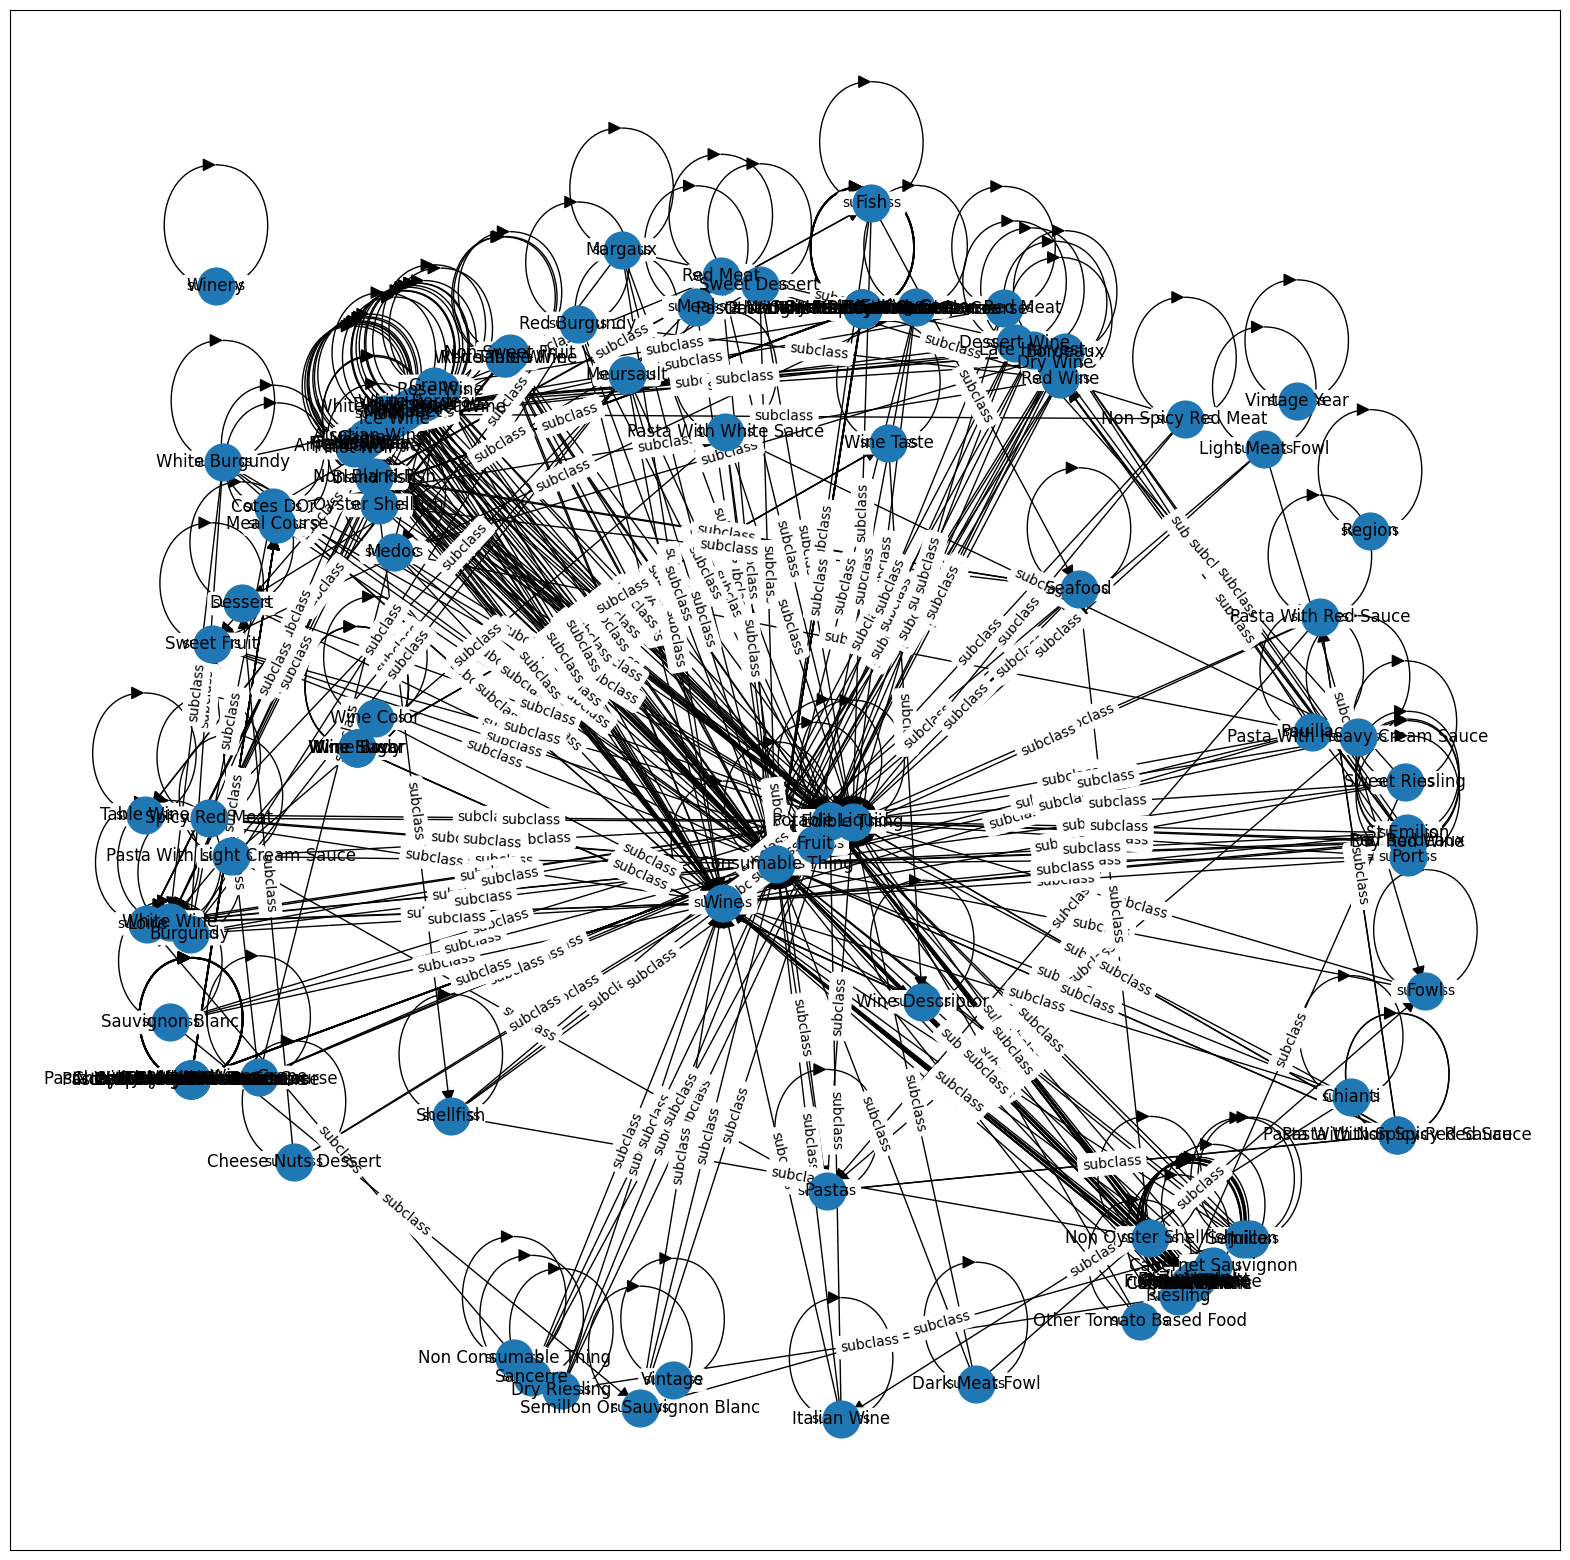

In [90]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
GX = nx.DiGraph()

for e in ents:
    GX.add_node(e, label=e)

for r in relations:
    GX.add_edge(r['source'], r['target'], label=r['rel'])

def plot_graph(G):
    plt.figure(figsize=(20,20))

    # Define node positions using a layout
    pos = nx.kamada_kawai_layout(G)

    # Draw the nodes with labels
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)

    # Draw the edges with labels
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))

    # Display the graph
    plt.show()

plot_graph(GX)

In [ ]:
def gen_tree(x):
    sub = [ gen_tree(r['source']) for r in relations if r['target']==x]
    if len(sub)==0:
        return x
    else:
        return { x : sub }
    
gen_tree("Italian Wine")
        

: 

In [83]:
def explore(x):
    anc = [ r['source'] for r in relations if r['target']==x]
    desc = [r['target'] for r in relations if r['source']==x]
    return anc, desc

explore("Wine")


(['Dessert Wine', 'Early Harvest', 'Late Harvest'], ['Potable Liquid'])

In [77]:
from rdflib import Graph, RDF, RDFS, OWL, Namespace

def extract_wine_info(graph):
    wine_info_list = []

    for wine in graph.subjects(RDF.type, OWL.Class):
        wine_name = wine.split('#')[-1]


        wine_info = {"wine": wine_name}

        # Extract properties
        properties = {
            "hasColor": None,
            "hasFlavor": None,
            "hasSugar": None,
            "hasBody": None,
            "madeFromGrape": []
        }

        # Extract properties directly from the class
        for restriction in graph.objects(wine, RDFS.subClassOf):
            if (restriction, RDF.type, OWL.Restriction) in graph:
                on_property = graph.value(restriction, OWL.onProperty)
                if on_property:
                    property_name = on_property.split('#')[-1]
                    if property_name in properties:
                        has_value = graph.value(restriction, OWL.hasValue)
                        if has_value:
                            properties[property_name] = has_value.split('#')[-1]

        # Extract properties from intersectionOf restrictions
        for collection in graph.objects(wine, OWL.intersectionOf):
            for member in collection:
                if (member, RDF.type, OWL.Restriction) in graph:
                    on_property = graph.value(member, OWL.onProperty)
                    if on_property:
                        property_name = on_property.split('#')[-1]
                        if property_name in properties:
                            all_values_from = graph.value(member, OWL.allValuesFrom)
                            if all_values_from:
                                for grape in graph.objects(all_values_from, OWL.oneOf):
                                    for grape_item in grape:
                                        properties["madeFromGrape"].append(grape_item.split('#')[-1])
                            min_cardinality = graph.value(member, OWL.minCardinality)
                            if min_cardinality:
                                properties["minCardinality"] = int(min_cardinality)

        # Filter out properties that are None or empty
        for key, value in properties.items():
            if value or (isinstance(value, list) and value):
                wine_info[key] = value

        wine_info_list.append(wine_info)

    return wine_info_list

extract_wine_info(G)

[{'wine': 'Wine'},
 {'wine': 'Vintage'},
 {'wine': 'WineGrape'},
 {'wine': 'WhiteWine'},
 {'wine': 'WhiteTableWine'},
 {'wine': 'TableWine'},
 {'wine': 'WhiteNonSweetWine'},
 {'wine': 'N7e535b6b524644ec9b435280ad1ad00e'},
 {'wine': 'WhiteLoire'},
 {'wine': 'Loire'},
 {'wine': 'N2eaa9a2a0b8d4f8b9319a41a0ef86375'},
 {'wine': 'WhiteBurgundy', 'madeFromGrape': 'ChardonnayGrape'},
 {'wine': 'Burgundy', 'hasSugar': 'Dry'},
 {'wine': 'WhiteBordeaux'},
 {'wine': 'Bordeaux'},
 {'wine': 'N6c2ec7be2e0d41b8b9532dc99db3b62f'},
 {'wine': 'Region'},
 {'wine': 'VintageYear'},
 {'wine': 'Zinfandel', 'hasColor': 'Red', 'hasSugar': 'Dry'},
 {'wine': 'Nc8e5123450b841faba4653685ed5eef4'},
 {'wine': 'N50ad34246fa940eab9bbffb785a3f070'},
 {'wine': 'Winery'},
 {'wine': 'WineDescriptor'},
 {'wine': 'WineTaste'},
 {'wine': 'WineColor'},
 {'wine': 'WineSugar'},
 {'wine': 'WineFlavor'},
 {'wine': 'WineBody'},
 {'wine': 'Tours', 'madeFromGrape': 'CheninBlancGrape'},
 {'wine': 'SweetWine'},
 {'wine': 'SweetRiesling

In [66]:
G = Graph().parse("../source/food.owl").parse("../source/wine.owl")

In [70]:
from owlrl import CombinedClosure, DeductiveClosure, OWLRL_Extension
#DeductiveClosure(OWLRL_Extension).expand(G)
print(len(G))
CombinedClosure.RDFS_OWLRL_Semantics(G,None,None).closure()
print(len(G))

3103
26552


In [73]:
q = """
SELECT ?p ?f ?w
WHERE {
    ?p rdfs:subClassOf :MealCourse .
    ?p rdfs:subClassOf [ owl:onProperty :hasFood ; owl:allValuesFrom ?f ] .
    ?p rdfs:subClassOf [ owl:onProperty :hasDrink ; owl:allValuesFrom ?w ] .
}
"""

for p,f,w in G.query(q):
    if isinstance(p,URIRef) and isinstance(f,URIRef) and isinstance(w,URIRef):
        print(p,f,w)

http://www.w3.org/2002/07/owl#Nothing http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#BlandFish http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Wine
http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#BlandFishCourse http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#BlandFish http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Wine
http://www.w3.org/2002/07/owl#Nothing http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#CheeseNutsDessert http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Wine
http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#CheeseNutsDessertCourse http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#CheeseNutsDessert http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Wine
http://www.w3.org/2002/07/owl#Nothing http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#DarkMeatFowl http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Wine
http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#DarkMeatFowlCourse http://www.w3.org/TR/2003/PR-owl-guide-20031

In [135]:
from owlready2 import *
onto = get_ontology("../source/food.owl").load()

In [136]:
list(onto.classes())

[food.Meal,
 food.MealCourse,
 food.PotableLiquid,
 food.EdibleThing,
 food.ConsumableThing,
 food.Fruit,
 food.BlandFish,
 food.Fish,
 food.NonBlandFish,
 food.BlandFishCourse,
 food.CheeseNutsDessert,
 food.Dessert,
 food.SweetDessert,
 food.CheeseNutsDessertCourse,
 food.DarkMeatFowl,
 food.Fowl,
 food.LightMeatFowl,
 food.DarkMeatFowlCourse,
 food.Meat,
 food.OtherTomatoBasedFood,
 food.Pasta,
 food.Seafood,
 food.DessertCourse,
 food.EatingGrape,
 food.Grape,
 food.Shellfish,
 food.FishCourse,
 food.NonSweetFruit,
 food.SweetFruit,
 food.FruitCourse,
 food.Juice,
 food.LightMeatFowlCourse,
 food.Wine,
 food.NonBlandFishCourse,
 food.NonConsumableThing,
 food.NonOysterShellfish,
 food.OysterShellfish,
 food.NonOysterShellfishCourse,
 food.NonRedMeat,
 food.RedMeat,
 food.NonRedMeatCourse,
 food.NonSpicyRedMeat,
 food.SpicyRedMeat,
 food.NonSpicyRedMeatCourse,
 food.NonSweetFruitCourse,
 food.OtherTomatoBasedFoodCourse,
 food.OysterShellfishCourse,
 food.PastaWithHeavyCreamCourse,
 

In [152]:
onto.SweetDessertCourse().INDIRECT_get_properties()

{food.hasDrink, food.hasFood}

In [168]:
onto.MealCourse.is_a

[food.ConsumableThing,
 food.hasDrink.only(food.Wine),
 food.hasDrink.min(1, owl.Thing),
 food.hasFood.min(1, owl.Thing)]

In [170]:
onto.SeafoodCourse.is_a

[owl.Thing, food.hasDrink.only(wine.hasColor.value(food.White))]

In [176]:
with onto:
    class MyCourse(onto.MealCourse):
        is_a = [onto.hasDrink.only(onto.wine.hasColor.value(onto.White))]


AttributeError: 'NoneType' object has no attribute 'hasColor'

In [173]:
print(onto.hasColor)

None
